In [19]:
import math
from simtk import unit
import os
import pickle
import mdtraj as md
import numpy as np
from simtk.unit.quantity import Quantity
from simtk.openmm import app
from openmmforcefields.generators import SystemGenerator
from perses.tests.test_topology_proposal import generate_atp, generate_dipeptide_top_pos_sys
import logging 

# Set up logger
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

from matplotlib import pyplot as plt


In [29]:
def plot_torsion_energy(torsion_force, hybrid_indices, atom_indices, topology, positions):
    # hybrid indices : for use in querying periodic torsion force for torsion parameters (of hybrid system)
    # atom_indices : for use in computing dihedrals given the old or new topology

    periodicities = []
    phase_offsets = []
    ks = []
    for i in range(torsion_force.getNumTorsions()):
        particle1, particle2, particle3, particle4, periodicity, phase, k = torsion_force.getTorsionParameters(i)
        if sorted([particle1, particle2, particle3, particle4]) == sorted(hybrid_indices):
            periodicities.append(periodicity)
            phase_offsets.append(phase)
            ks.append(k)
    print(f"periodicities: {periodicities}")
    print(f"phase offsets: {phase_offsets}")
    print(f"ks: {ks}")
    
    # Get angles
    angles = np.linspace(-np.pi, np.pi, endpoint=True, num=10)
    print(f"angles: {angles}")
    
    # Compute energies
    # (http://docs.openmm.org/latest/userguide/theory.html#periodictorsionforce)
    def f(periodicity, angle, phase_offset, k):
        return k*(1 + np.cos(periodicity*angle - phase_offset))
    
    energies = []
    for angle in angles:
        terms = []
        for periodicity, phase, k in zip(periodicities, phase_offsets, ks):
            terms.append(f(periodicity, angle, phase.value_in_unit_system(unit.md_unit_system), k.value_in_unit_system(unit.md_unit_system)))
        energies.append(np.sum(terms))
    print(f"energies: {energies}")
    
    # Plot the torsion energies in the order in which they appear in the torsion force
    plt.plot(angles, energies)
    plt.xlabel('radians')
    plt.ylabel('Torsion energy')
    plt.ylim(0, 10)
    plt.show()

# THR-ALA

In [21]:
htf = pickle.load(open("/data/chodera/zhangi/perses_benchmark/neq/7/23/23_vacuum.pickle", "rb" ))

### THR

In [22]:
htf.old_to_hybrid_atom_map

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 21: 21,
 22: 22,
 23: 23,
 24: 24,
 25: 25}

In [23]:
for atom in htf._topology_proposal.old_topology.atoms():
    print(atom)

<Atom 0 (H1) of chain 0 residue 0 (ACE)>
<Atom 1 (CH3) of chain 0 residue 0 (ACE)>
<Atom 2 (H2) of chain 0 residue 0 (ACE)>
<Atom 3 (H3) of chain 0 residue 0 (ACE)>
<Atom 4 (C) of chain 0 residue 0 (ACE)>
<Atom 5 (O) of chain 0 residue 0 (ACE)>
<Atom 6 (N) of chain 0 residue 1 (THR)>
<Atom 7 (H) of chain 0 residue 1 (THR)>
<Atom 8 (CA) of chain 0 residue 1 (THR)>
<Atom 9 (HA) of chain 0 residue 1 (THR)>
<Atom 10 (CB) of chain 0 residue 1 (THR)>
<Atom 11 (C) of chain 0 residue 1 (THR)>
<Atom 12 (O) of chain 0 residue 1 (THR)>
<Atom 13 (HB) of chain 0 residue 1 (THR)>
<Atom 14 (CG2) of chain 0 residue 1 (THR)>
<Atom 15 (HG21) of chain 0 residue 1 (THR)>
<Atom 16 (HG22) of chain 0 residue 1 (THR)>
<Atom 17 (HG23) of chain 0 residue 1 (THR)>
<Atom 18 (OG1) of chain 0 residue 1 (THR)>
<Atom 19 (HG1) of chain 0 residue 1 (THR)>
<Atom 20 (N) of chain 0 residue 2 (NME)>
<Atom 21 (H) of chain 0 residue 2 (NME)>
<Atom 22 (C) of chain 0 residue 2 (NME)>
<Atom 23 (H1) of chain 0 residue 2 (NME)>
<

In [24]:
for i in range(htf.hybrid_system.getNumForces()):
    print(i, htf.hybrid_system.getForce(i))

0 <simtk.openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2b16d8730900> >
1 <simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x2b16d8730900> >
2 <simtk.openmm.openmm.CustomAngleForce; proxy of <Swig Object of type 'OpenMM::CustomAngleForce *' at 0x2b16d8730900> >
3 <simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x2b16d8730900> >
4 <simtk.openmm.openmm.CustomTorsionForce; proxy of <Swig Object of type 'OpenMM::CustomTorsionForce *' at 0x2b16d8730900> >
5 <simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x2b16d8730900> >
6 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2b16d8730900> >
7 <simtk.openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x2b16d8730900> >
8 <simtk.ope

In [25]:
torsion_force = htf.hybrid_system.getForce(5)
for i in range(torsion_force.getNumTorsions()):
    print(torsion_force.getTorsionParameters(i))

[6, 8, 10, 14, 4, Quantity(value=3.141592653589793, unit=radian), Quantity(value=0.004184, unit=kilojoule/mole)]
[6, 8, 10, 14, 3, Quantity(value=0.0, unit=radian), Quantity(value=0.619232, unit=kilojoule/mole)]
[6, 8, 10, 14, 2, Quantity(value=3.141592653589793, unit=radian), Quantity(value=0.903744, unit=kilojoule/mole)]
[6, 8, 10, 14, 1, Quantity(value=0.0, unit=radian), Quantity(value=1.4100080000000002, unit=kilojoule/mole)]
[6, 8, 10, 18, 4, Quantity(value=0.0, unit=radian), Quantity(value=0.39748, unit=kilojoule/mole)]
[6, 8, 10, 18, 3, Quantity(value=0.0, unit=radian), Quantity(value=1.31796, unit=kilojoule/mole)]
[6, 8, 10, 18, 2, Quantity(value=0.0, unit=radian), Quantity(value=0.025104, unit=kilojoule/mole)]
[6, 8, 10, 18, 1, Quantity(value=0.0, unit=radian), Quantity(value=2.8200160000000003, unit=kilojoule/mole)]
[8, 10, 14, 15, 3, Quantity(value=0.0, unit=radian), Quantity(value=0.66944, unit=kilojoule/mole)]
[8, 10, 14, 16, 3, Quantity(value=0.0, unit=radian), Quantity(v

periodicities: [4, 3, 2, 1]
phase offsets: [Quantity(value=0.0, unit=radian), Quantity(value=0.0, unit=radian), Quantity(value=0.0, unit=radian), Quantity(value=0.0, unit=radian)]
ks: [Quantity(value=0.39748, unit=kilojoule/mole), Quantity(value=1.31796, unit=kilojoule/mole), Quantity(value=0.025104, unit=kilojoule/mole), Quantity(value=2.8200160000000003, unit=kilojoule/mole)]
angles: [-3.14159265 -2.44346095 -1.74532925 -1.04719755 -0.34906585  0.34906585
  1.04719755  1.74532925  2.44346095  3.14159265]
energies: [0.845168, 2.6901326546355606, 5.010746662307136, 4.4413160000000005, 7.957740683057306, 7.957740683057306, 4.441316000000001, 5.010746662307136, 2.6901326546355606, 0.845168]


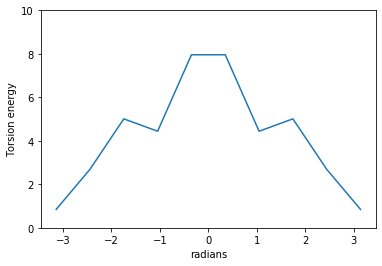

In [30]:
torsion_force = htf.hybrid_system.getForce(5)
plot_torsion_energy(torsion_force, [18, 10, 8, 6], [18, 10, 8, 6], htf._topology_proposal.old_topology, np.array(htf.old_positions(htf.hybrid_positions)))

In [ ]:
# Check terms in CustomTorsionForce
torsion_force = htf.hybrid_system.getForce(4)
plot_torsion_energy(torsion_force, [18, 10, 8, 6], [18, 10, 8, 6], htf._topology_proposal.old_topology, np.array(htf.old_positions(htf.hybrid_positions)))

In [ ]:
# Check terms in CustomTorsionForce
for i in range(torsion_force.getNumTorsions()):
    print(torsion_force.getTorsionParameters(i))

### ALA

In [11]:
htf.new_to_hybrid_atom_map

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 16: 20,
 17: 21,
 18: 22,
 19: 23,
 20: 24,
 21: 25,
 14: 26,
 15: 27}

In [12]:
for atom in htf._topology_proposal.new_topology.atoms():
    print(atom)

<Atom 0 (H1) of chain 0 residue 0 (ACE)>
<Atom 1 (CH3) of chain 0 residue 0 (ACE)>
<Atom 2 (H2) of chain 0 residue 0 (ACE)>
<Atom 3 (H3) of chain 0 residue 0 (ACE)>
<Atom 4 (C) of chain 0 residue 0 (ACE)>
<Atom 5 (O) of chain 0 residue 0 (ACE)>
<Atom 6 (N) of chain 0 residue 1 (ALA)>
<Atom 7 (H) of chain 0 residue 1 (ALA)>
<Atom 8 (CA) of chain 0 residue 1 (ALA)>
<Atom 9 (HA) of chain 0 residue 1 (ALA)>
<Atom 10 (CB) of chain 0 residue 1 (ALA)>
<Atom 11 (C) of chain 0 residue 1 (ALA)>
<Atom 12 (O) of chain 0 residue 1 (ALA)>
<Atom 13 (HB1) of chain 0 residue 1 (ALA)>
<Atom 14 (HB2) of chain 0 residue 1 (ALA)>
<Atom 15 (HB3) of chain 0 residue 1 (ALA)>
<Atom 16 (N) of chain 0 residue 2 (NME)>
<Atom 17 (H) of chain 0 residue 2 (NME)>
<Atom 18 (C) of chain 0 residue 2 (NME)>
<Atom 19 (H1) of chain 0 residue 2 (NME)>
<Atom 20 (H2) of chain 0 residue 2 (NME)>
<Atom 21 (H3) of chain 0 residue 2 (NME)>


periodicities: [3]
phase offsets: [Quantity(value=0.0, unit=radian)]
ks: [Quantity(value=0.6508444444444444, unit=kilojoule/mole)]
angles: [-3.14159265 -2.44346095 -1.74532925 -1.04719755 -0.34906585  0.34906585
  1.04719755  1.74532925  2.44346095  3.14159265]
energies: [0.0, 0.976266666666667, 0.9762666666666666, 0.0, 0.9762666666666666, 0.9762666666666666, 0.0, 0.9762666666666663, 0.976266666666667, 0.0]


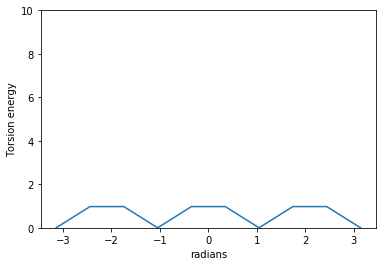

In [31]:
torsion_force = htf.hybrid_system.getForce(5)
plot_torsion_energy(torsion_force, [13, 10, 8, 6], [13, 10, 8, 6], htf._topology_proposal.new_topology, np.array(htf.new_positions(htf.hybrid_positions)))

# ALA->THR lambda=0

In [32]:
htf = pickle.load(open("/data/chodera/zhangi/perses_benchmark/neq/7/22/22_vacuum.pickle", "rb" ))

### THR

In [33]:
htf.new_to_hybrid_atom_map

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 13,
 12: 14,
 20: 16,
 21: 17,
 22: 18,
 23: 19,
 24: 20,
 25: 21,
 13: 22,
 14: 23,
 15: 24,
 16: 25,
 17: 26,
 18: 27,
 19: 28}

In [34]:
for atom in htf._topology_proposal.new_topology.atoms():
    print(atom)

<Atom 0 (H1) of chain 0 residue 0 (ACE)>
<Atom 1 (CH3) of chain 0 residue 0 (ACE)>
<Atom 2 (H2) of chain 0 residue 0 (ACE)>
<Atom 3 (H3) of chain 0 residue 0 (ACE)>
<Atom 4 (C) of chain 0 residue 0 (ACE)>
<Atom 5 (O) of chain 0 residue 0 (ACE)>
<Atom 6 (N) of chain 0 residue 1 (THR)>
<Atom 7 (H) of chain 0 residue 1 (THR)>
<Atom 8 (CA) of chain 0 residue 1 (THR)>
<Atom 9 (HA) of chain 0 residue 1 (THR)>
<Atom 10 (CB) of chain 0 residue 1 (THR)>
<Atom 11 (C) of chain 0 residue 1 (THR)>
<Atom 12 (O) of chain 0 residue 1 (THR)>
<Atom 13 (HB) of chain 0 residue 1 (THR)>
<Atom 14 (CG2) of chain 0 residue 1 (THR)>
<Atom 15 (HG21) of chain 0 residue 1 (THR)>
<Atom 16 (HG22) of chain 0 residue 1 (THR)>
<Atom 17 (HG23) of chain 0 residue 1 (THR)>
<Atom 18 (OG1) of chain 0 residue 1 (THR)>
<Atom 19 (HG1) of chain 0 residue 1 (THR)>
<Atom 20 (N) of chain 0 residue 2 (NME)>
<Atom 21 (H) of chain 0 residue 2 (NME)>
<Atom 22 (C) of chain 0 residue 2 (NME)>
<Atom 23 (H1) of chain 0 residue 2 (NME)>
<

periodicities: [4, 3, 2, 1]
phase offsets: [Quantity(value=0.0, unit=radian), Quantity(value=0.0, unit=radian), Quantity(value=0.0, unit=radian), Quantity(value=0.0, unit=radian)]
ks: [Quantity(value=0.39748, unit=kilojoule/mole), Quantity(value=1.31796, unit=kilojoule/mole), Quantity(value=0.025104, unit=kilojoule/mole), Quantity(value=2.8200160000000003, unit=kilojoule/mole)]
angles: [-3.14159265 -2.44346095 -1.74532925 -1.04719755 -0.34906585  0.34906585
  1.04719755  1.74532925  2.44346095  3.14159265]
energies: [0.845168, 2.6901326546355606, 5.010746662307136, 4.4413160000000005, 7.957740683057306, 7.957740683057306, 4.441316000000001, 5.010746662307136, 2.6901326546355606, 0.845168]


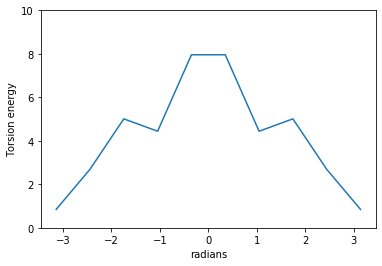

In [35]:
torsion_force = htf.hybrid_system.getForce(5)
plot_torsion_energy(torsion_force, [27, 10, 8, 6], [18, 10, 8, 6], htf._topology_proposal.new_topology, np.array(htf.new_positions(htf.hybrid_positions)))

### ALA

In [36]:
for atom in htf._topology_proposal.old_topology.atoms():
    print(atom)

<Atom 0 (H1) of chain 0 residue 0 (ACE)>
<Atom 1 (CH3) of chain 0 residue 0 (ACE)>
<Atom 2 (H2) of chain 0 residue 0 (ACE)>
<Atom 3 (H3) of chain 0 residue 0 (ACE)>
<Atom 4 (C) of chain 0 residue 0 (ACE)>
<Atom 5 (O) of chain 0 residue 0 (ACE)>
<Atom 6 (N) of chain 0 residue 1 (ALA)>
<Atom 7 (H) of chain 0 residue 1 (ALA)>
<Atom 8 (CA) of chain 0 residue 1 (ALA)>
<Atom 9 (HA) of chain 0 residue 1 (ALA)>
<Atom 10 (CB) of chain 0 residue 1 (ALA)>
<Atom 11 (HB2) of chain 0 residue 1 (ALA)>
<Atom 12 (HB3) of chain 0 residue 1 (ALA)>
<Atom 13 (C) of chain 0 residue 1 (ALA)>
<Atom 14 (O) of chain 0 residue 1 (ALA)>
<Atom 15 (HB1) of chain 0 residue 1 (ALA)>
<Atom 16 (N) of chain 0 residue 2 (NME)>
<Atom 17 (H) of chain 0 residue 2 (NME)>
<Atom 18 (C) of chain 0 residue 2 (NME)>
<Atom 19 (H1) of chain 0 residue 2 (NME)>
<Atom 20 (H2) of chain 0 residue 2 (NME)>
<Atom 21 (H3) of chain 0 residue 2 (NME)>


In [37]:
htf.old_to_hybrid_atom_map

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 21: 21}

periodicities: [3]
phase offsets: [Quantity(value=0.0, unit=radian)]
ks: [Quantity(value=0.6508444444444444, unit=kilojoule/mole)]
angles: [-3.14159265 -2.44346095 -1.74532925 -1.04719755 -0.34906585  0.34906585
  1.04719755  1.74532925  2.44346095  3.14159265]
energies: [0.0, 0.976266666666667, 0.9762666666666666, 0.0, 0.9762666666666666, 0.9762666666666666, 0.0, 0.9762666666666663, 0.976266666666667, 0.0]


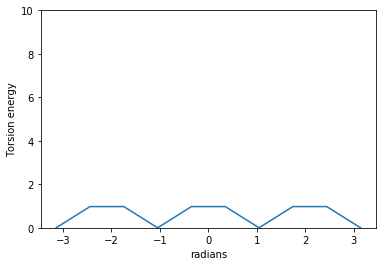

In [38]:
torsion_force = htf.hybrid_system.getForce(5)
plot_torsion_energy(torsion_force, [15, 10, 8, 6], [15, 10, 8, 6], htf._topology_proposal.old_topology, np.array(htf.old_positions(htf.hybrid_positions)))